In [1]:
import numpy as np
import scipy as sp
import scipy.special as sps
import scipy.constants as cons
import matplotlib.pyplot as plt

In [2]:
def position(theta, length):
    pos = np.array([np.sin(theta)*length, -np.cos(theta)*length]).T
    return pos

In [3]:
def get_alpha(theta, length):
        return -cons.g/length * np.sin(theta)

In [4]:
def runge_kutta_1(theta, omega, length, dt=1e-3):   
    alpha = get_alpha(theta, length)
    nomega = omega + alpha*dt
    # ntheta = (theta + nomega*dt) % (2*np.pi)
    ntheta = theta + nomega*dt
    return ntheta, nomega

In [95]:
def runge_kutta_2(theta, omega, length, dt=1e-3):

    k1o = get_alpha(theta, length)*dt
    k1t = omega*dt

    k2o = get_alpha(theta+0.5*k1t, length)*dt
    k2t = (omega + 0.5*k1o)*dt

    nomega = omega + k2o
    ntheta = theta + k2t

    return ntheta, nomega


In [96]:
def runge_kutta_3(theta, omega, length, dt=1e-3):

    k1o = get_alpha(theta, length)*dt
    k1t = omega*dt

    k2o = get_alpha(theta+0.5*k1t, length)*dt
    k2t = (omega + 0.5*k1o)*dt

    k3o = get_alpha(theta+(2*k2t - k1t), length)*dt
    k3t = (omega + (2*k2o-k1o))*dt

    nomega = omega + (k1o + 4*k2o + k3o)/6
    ntheta = theta + (k1t + 4*k2t + k3t)/6

    return ntheta, nomega

In [97]:
def runge_kutta_4(theta, omega, length, dt=1e-3):

    k1o = get_alpha(theta, length)*dt
    k1t = omega*dt

    k2o = get_alpha(theta+0.5*k1t, length)*dt
    k2t = (omega + 0.5*k1o)*dt

    k3o = get_alpha(theta+0.5*k2t, length)*dt
    k3t = (omega + 0.5*k2o)*dt

    k4o = get_alpha(theta+k3t, length)*dt
    k4t = (omega + k3o)*dt

    nomega = omega + (k1o + 2*k2o + 2*k3o + k4o)/6
    ntheta = theta + (k1t + 2*k2t + 2*k3t + k4t)/6

    return ntheta, nomega

In [125]:
K = sps.ellipk

def q(m):
    return np.exp(-np.pi*K(1-m)/K(m))

def theta_s(z, m):
    a = ((np.sqrt(2*np.pi)*(q(m))**(1/4))/((m*(1-m))**(1/4)*np.sqrt(K(m))))
    k = np.arange(10000)
    sum = np.sum( (-1)**k * ((q(m))**(k*(k+1))) * np.sin(((2*k+1)*np.pi*z) / (2*K(m))) )
    # for k in range(10000):
    #     sum = sum + (-1)**k * ((q(m))**(k*(k+1))) * np.sin(((2*k+1)*np.pi*z) / (2*K(m)))
    return a * sum

def theta_n(z, m):
    a = ((np.sqrt(2*np.pi))/(2*(1-m)**(1/4)*np.sqrt(K(m))))
    k = np.arange(1, 10000)
    sum = np.sum( (-1)**k * ((q(m))**(k**2)) * np.cos((k*np.pi*z) / (K(m))) )
    # for k in range(10000):
    #     sum = sum + (-1)**k * ((q(m))**(k*(k+1))) * np.sin(((2*k+1)*np.pi*z) / (2*K(m)))
    return a * (1+2*sum) 

def sn(z, m):
    return theta_s(z, m)/theta_n(z, m)

def theta_analytic(t, theta_0, length):
    omega_0 = np.sqrt(9.81/length)
    return 2*np.arcsin(np.sin(theta_0/2) * sn(K(np.sin(theta_0/2)) - omega_0*t, (np.sin(theta_0/2))**2))

In [113]:
def simulate(times, theta_0, length, dt=1e-3, step_fn=runge_kutta_1):
    # times = np.arange(num_steps)*dt
    num_steps = len(times)
    pos = np.ndarray((num_steps, 2))
    theta_arr = np.zeros(num_steps)
    theta = theta_0
    omega = 0
    for t in range(num_steps):
        theta_arr[t] = theta
        theta, omega = step_fn(theta, omega, length, dt)
    return theta_arr

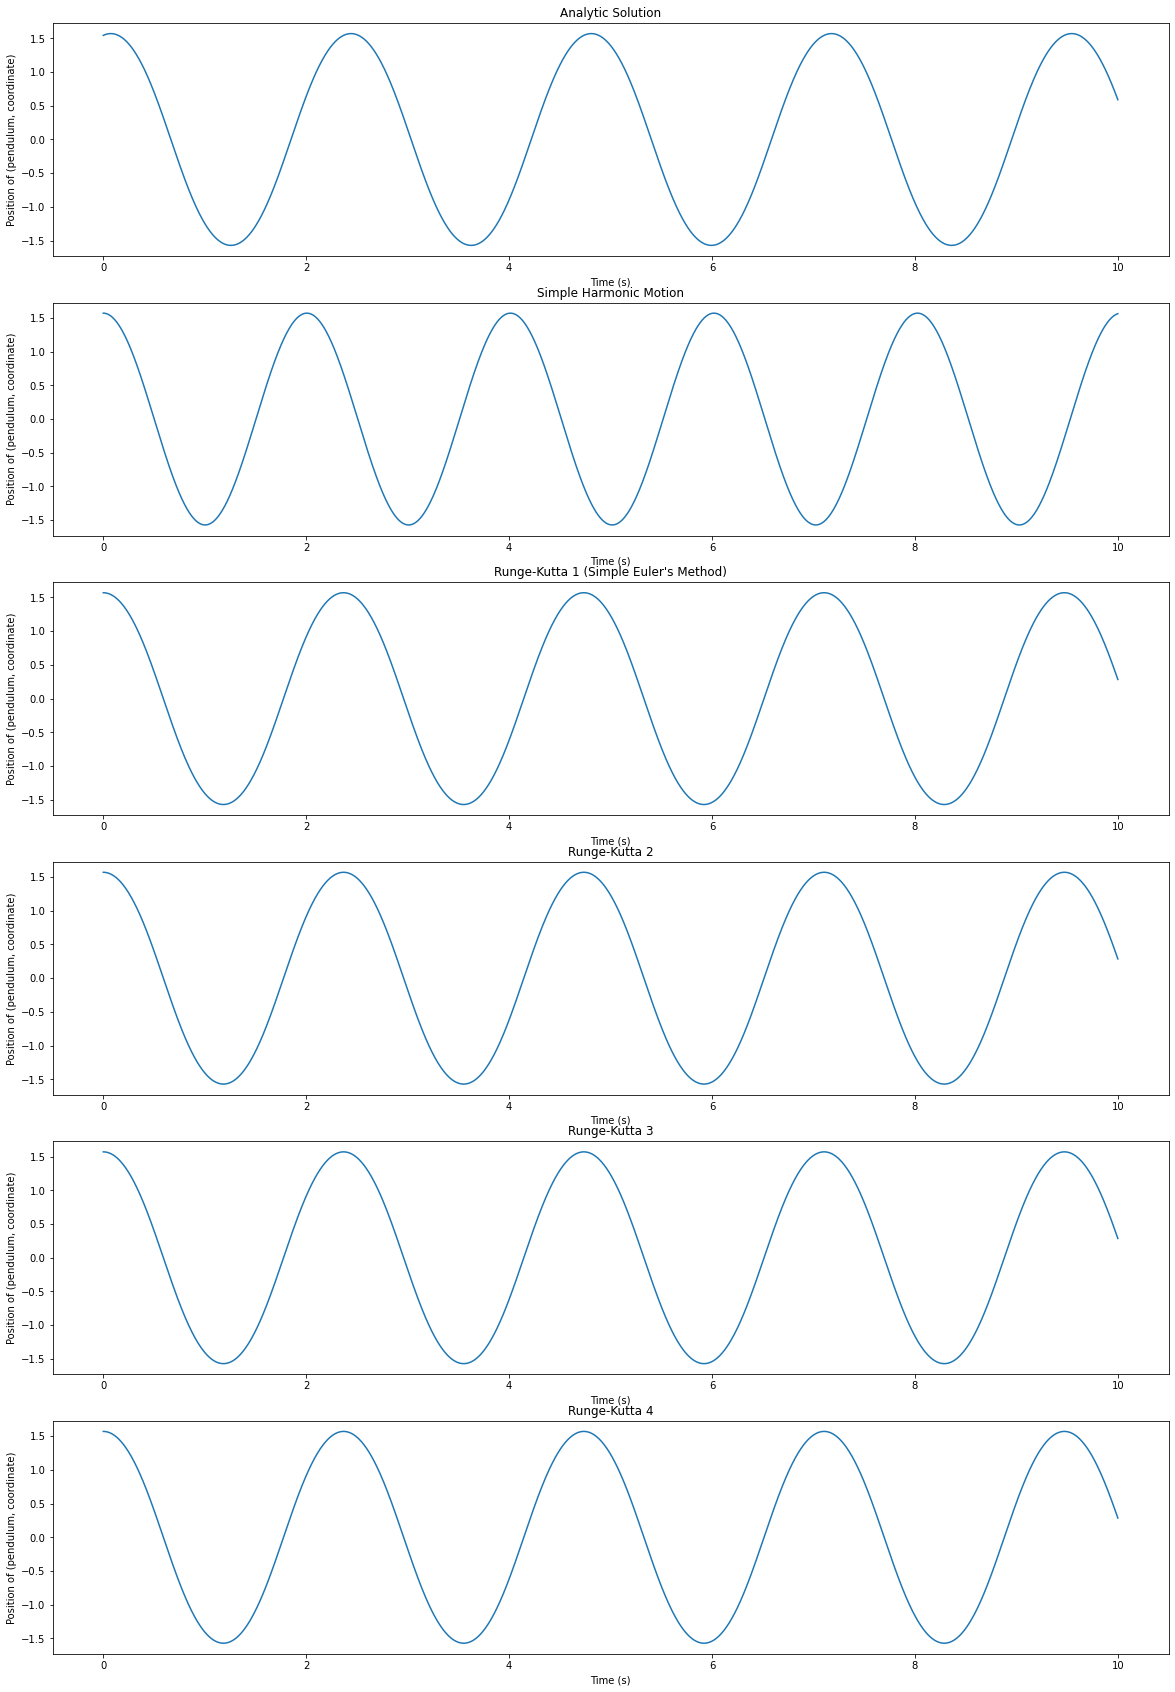

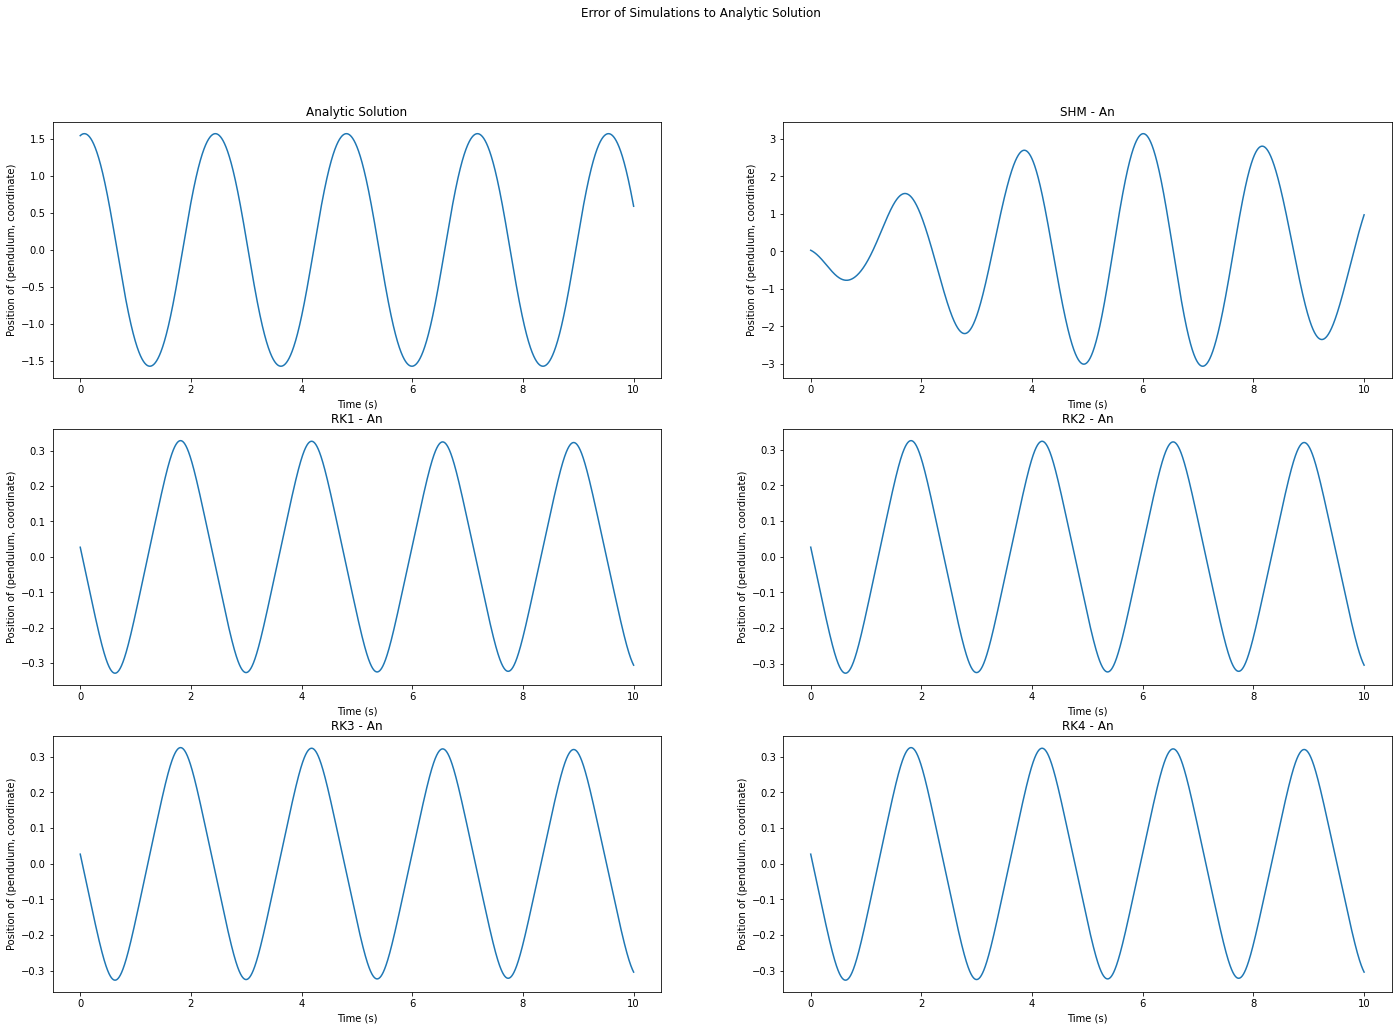

In [126]:
theta_0 = np.pi / 180 * np.array([90])
length = np.array(1)
duration = 10
deltatime = 1e-3
times = np.arange(0, duration+deltatime, deltatime)

theta_an = np.array([theta_analytic(t, theta_0, length) for t in times]).T[0]
theta_shm = theta_0 * np.cos( np.sqrt(cons.g / length) * times)
theta_rk1 = simulate(times, theta_0, length, step_fn=runge_kutta_1, dt=deltatime)
theta_rk2 = simulate(times, theta_0, length, step_fn=runge_kutta_2, dt=deltatime)
theta_rk3 = simulate(times, theta_0, length, step_fn=runge_kutta_3, dt=deltatime)

fig_sim, axs = plt.subplots(6, figsize=(20,30))
# fig_sim.suptitle(r"$Simulations$", size='xx-large')
for ax in axs:
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("Position of (pendulum, coordinate)")

ax = axs[0]
ax.plot(times, theta_an)
ax.set_xlabel("Time (s)")
ax.set_ylabel("Position of (pendulum, coordinate)")
ax.set_title("Analytic Solution")

ax = axs[1]
ax.plot(times, theta_shm)
ax.set_title("Simple Harmonic Motion")

ax = axs[2]
ax.plot(times, theta_rk1)
ax.set_title("Runge-Kutta 1 (Simple Euler's Method)")

ax = axs[3]
ax.plot(times, theta_rk2)
ax.set_title("Runge-Kutta 2")

ax = axs[4]
ax.plot(times, theta_rk3)
ax.set_title("Runge-Kutta 3")

theta_rk4 = simulate(times, theta_0, length, step_fn=runge_kutta_4, dt=deltatime)
ax = axs[5]
ax.plot(times, theta_rk4)
ax.set_title("Runge-Kutta 4")
plt.show()

fig_error, axs = plt.subplots(3,2, figsize=(24, 16))
fig_error.suptitle("Error of Simulations to Analytic Solution")

ax = axs[0,0]
ax.plot(times, theta_an)
ax.set_title(r"Analytic Solution")

ax = axs[0,1]
ax.plot(times, theta_shm-theta_an)
ax.set_title(r'SHM - An')

ax = axs[1,0]
ax.plot(times, theta_rk1-theta_an)
ax.set_title(r'RK1 - An')

ax = axs[1,1]
ax.plot(times, theta_rk2-theta_an)
ax.set_title(r'RK2 - An')

ax = axs[2,0]
ax.set_title(r'RK3 - An')
ax.plot(times, theta_rk3-theta_an)

ax = axs[2,1]
ax.plot(times, theta_rk4-theta_an)
ax.set_title(r'RK4 - An')

for ax in axs.ravel():
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("Position of (pendulum, coordinate)")

plt.show()

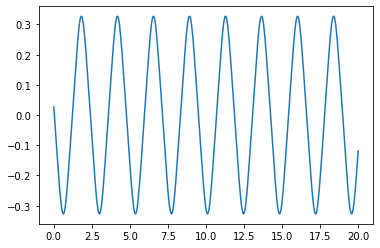

In [94]:
import csv
f_csv = open('keisan.csv', 'r')
read_rk4 = csv.reader(f_csv, delimiter=',')

keitimes = []
keithetas = []

for row in read_rk4:
    keitimes.append(float(row[0]))
    keithetas.append(float(row[1]))

keitimes = np.array(keitimes)
keithetas = np.array(keithetas)

plt.plot(keitimes, keithetas-theta_an)